In [16]:
import sys
sys.path.append('/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/')

from src.GradShafranovCutFEM import *

### LOCATION OF FOLDERS
folder_MESHES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/MESHES/'   # MESHES
folder_CASES = '/home/elmanyer/Documents/BSC/MasterThesis/Code/EQUILI_PY/CASES/'     # CASES

### SELECT MESH FOLDER...
#MESH = 'TS-UNSTRUCTURED_ULTRACOARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE'
#MESH = 'TS-UNSTRUCTURED_COARSE-FINE'
MESH = 'TS-UNSTRUCTURED_FINE'
#MESH = 'TS-UNSTRUCTURED_ULTRAFINE'

# ... WITH MESH ELEMENTS:
ElementType = 1     # Element type -> 1: TRIANGLE  ; 2: QUADRILATERAL
ElementOrder = 1    # Element order -> 1: LINEAR  ; 2: QUADRATIC ; 3: CUBIC ...

### SELECT SOLUTION CASE FILE:
CASE = 'TS-FIXED-LINEAR'         # FIXED PLASMA BOUNDARY AND LINEAR ANALYTICAL SOLUTION
#CASE = 'TS-FIXED-NONLINEAR'     # FIXED PLASMA BOUNDARY AND NONLINEAR ANALYTICAL SOLUTION
#CASE = 'TS-FREE-CASE0'          # FREE PLASMA BOUNDARY

# SELECT ORDER OF NUMERICAL INTEGRATION QUADRATURE
QuadratureOrder = 2

##############################################################

# DECLARE OBJECT PROBLEM 
Problem = GradShafranovCutFEM(folder_MESHES+MESH,folder_CASES+CASE,ElementType,ElementOrder,QuadratureOrder)

Problem.ReadMesh()
Problem.ReadEQUILIdata()

     -> READ MESH DATA FILES...Done!
     -> READ EQUILI DATA FILE...Done!


/tmp/ipykernel_121774/3600337437.py:20: UserWarning: No contour levels were found within the data range.
  axs[1].tricontour(X[:,0],X[:,1], FIELD2, levels=[0], colors = 'red')


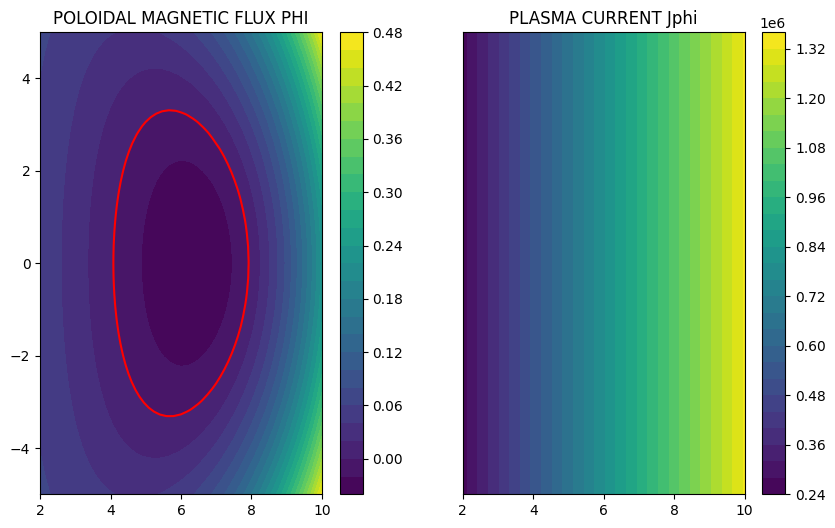

In [77]:
def PlotFields(X,FIELD1,FIELD2,title1,title2):
    if len(np.shape(FIELD1)) == 2:
        FIELD1 = FIELD1[:,0]
    if len(np.shape(FIELD2)) == 2:
        FIELD2 = FIELD2[:,0]
        
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    for i in range(2):
        axs[i].set_ylim(np.min(X[:,1]),np.max(X[:,1]))
        axs[i].set_xlim(np.min(X[:,0]),np.max(X[:,0]))
        
    # LEFT PLOT: PHI
    a1 = axs[0].tricontourf(X[:,0],X[:,1], FIELD1, levels=30)
    axs[0].tricontour(X[:,0],X[:,1], FIELD1, levels=[0], colors = 'red')
    axs[0].set_title(title1)
    plt.colorbar(a1, ax=axs[0])
    
    # RIGHT PLOT: Jphi
    a2 = axs[1].tricontourf(X[:,0],X[:,1], FIELD2, levels=30)
    axs[1].tricontour(X[:,0],X[:,1], FIELD2, levels=[0], colors = 'red')
    axs[1].set_title(title2)
    axs[1].yaxis.set_visible(False)
    plt.colorbar(a2, ax=axs[1])
    
    plt.show()
    
PHIexact = np.zeros([Problem.Nn])
Jphi = np.zeros([Problem.Nn])

for i in range(Problem.Nn):
    PHIexact[i] = Problem.SolutionCASE(Problem.X[i,:])
    Jphi[i] = Problem.Jphi(Problem.X[i,0],Problem.X[i,1],PHIexact[i])
    
PlotFields(Problem.X,PHIexact,Jphi,title1 = 'POLOIDAL MAGNETIC FLUX PHI', title2 = 'PLASMA CURRENT Jphi')

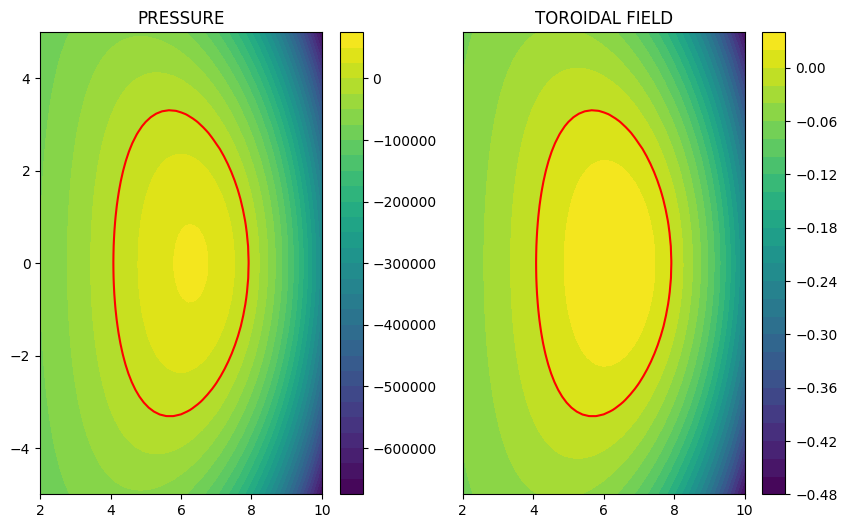

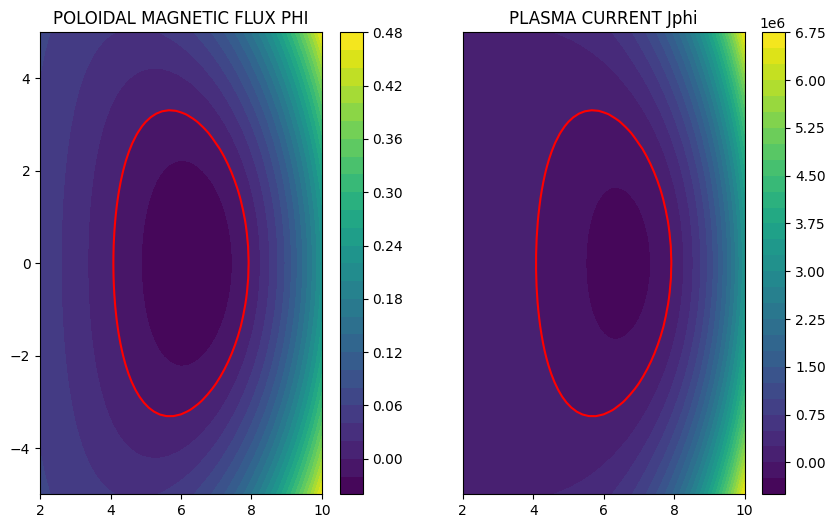

In [85]:
# FORTRAN INITIAL GUESS AND PLASMA CURRENT MODELISATION

def PHI_ini(X,B0,k0,q0,R0):
   PHI = 0.5*B0/(R0**2*q0*k0)*((X[0]*X[1])**2 + 0.25*k0**2*(X[0]**2-R0**2)**2)
   #phipol(ipoin,1) = phipol(ipoin,1)/100
   return PHI

# FUNCTION MODELLING PLASMA PRESSURE PROFILE
def funP(phi,pbarra0,n_p):
   funp = -pbarra0*n_p*phi**(n_p-1)
   return funp
# FUNCTION MODELLING TOROIDAL FIELD FUNCTION PROFILE
def funG(phi,gbarra0,n_g):
   fung = -0.5 * gbarra0**2 * n_g* phi**(n_g-1)
   return fung

def Jphi_free(X,PHI,mu0,pbarra0,n_p,gbarra0,n_g):
   # COMPUTE PLASMA CURRENT
   funJphi = -X[0] * funP(PHI,pbarra0,n_p) - funG(PHI,gbarra0,n_g)/ (X[0]*mu0) 
   return funJphi

# PARAMETERS
B0=10.0                                      # campo toroidal en el eje magentico H?
q0=0.7                                       # parametro de seguridad del tokamak

# PARAMETERS FOR PLASMA PRESSURE MODEL
p0=B0*(Problem.kappa**2+1)/(Problem.mu0*Problem.R0**2*q0*Problem.kappa)
n_p=2
# PARAMETERS FOR TOROIDAL FIELD FUNCTION MODEL
g0=1.0
n_g=2

PHIexact = np.zeros([Problem.Nn])
Pmodel = np.zeros([Problem.Nn])
Gmodel = np.zeros([Problem.Nn])
Jphi = np.zeros([Problem.Nn])
for i in range(Problem.Nn):
    #PHIexact[i] = PHI_ini(Problem.X[i,:],B0,Problem.kappa,q0,Problem.R0)/650
    PHIexact[i] = Problem.SolutionCASE(Problem.X[i,:])
    Pmodel[i] = funP(PHIexact[i],p0,n_p)
    Gmodel[i] = funG(PHIexact[i],g0,n_g)
    Jphi[i] = Jphi_free(Problem.X[i,:],PHIexact[i],Problem.mu0,p0,n_p,g0,n_g)
    
PlotFields(Problem.X,Pmodel,Gmodel,title1 = 'PRESSURE', title2 = 'TOROIDAL FIELD')
PlotFields(Problem.X,PHIexact,Jphi,title1 = 'POLOIDAL MAGNETIC FLUX PHI', title2 = 'PLASMA CURRENT Jphi')

